# Neural Networks I
G. Richards
(2016, 2018, 2020, 2022)
[Ivezic 9.8](https://www.astroml.org/book_figures/chapter9/index.html) and [Geron](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_5?dchild=1&keywords=machine+learning&qid=1596499152&sr=8-5).   With updates to my own class from [Stephen Taylor's class at Vanderbilt](https://github.com/VanderbiltAstronomy/astr_8070_s22).

I found this video series particularly helpful in trying to simplify the explanation https://www.youtube.com/watch?v=bxe2T-V8XRs. 


- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 9.
- Many blogs and videos.
- Free online book! http://neuralnetworksanddeeplearning.com/index.html

## Contents

* [Preliminaries](#one)
* [Neural networks](#two)
* [Activation Functions](#three)
* [Keras](#four)
* [Regularization](#five)
* [Batch Normalization](#six)

## Preliminaries <a class="anchor" id="one"></a>

Before starting today, let's install some software, including the two big Deep Learning packages out there. [Tensorflow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/)-- the rivalry essentially boils down to Google versus Facebook.  See the cells below.  Go ahead and do this while you are waiting for lecture to start.

We won't make much use of these today.  Mostly we need them for the next lecture. So, you'll have the weekend to debug if you have problems.

On the command line:
    
% pip3 install --upgrade pip
    
% pip3 install tensorflow --upgrade

% pip3 install torch

% pip3 install pydot

If you have a Mac M1 (or newer) computer, have a look at

[https://developer.apple.com/metal/tensorflow-plugin/](https://developer.apple.com/metal/tensorflow-plugin/)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
import tensorflow as tf
#import tensorflow_datasets as tfds
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

In [ ]:
from tensorflow import keras
print(keras.__version__)

## Neural Networks  <a class="anchor" id="two"></a>

[Artificial Neural Networks](https://en.wikipedia.org/wiki/Artificial_neural_network) are a simplified computation architecture based loosely on the real neural networks found in brains. 

![Neuron example](https://4.bp.blogspot.com/-Z5LfY6yoIcE/U-OFKWHoAbI/AAAAAAAAAKo/ytH6BzDLeo4/s1600/Picture-533.png)

In reality, what we are going to explore is a **[multi-layer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)**.

In the image below, 
- the circles on the ***left*** represent the **features/attributes** of our input data, $X$, which here is 3 dimensional.  
- the circles in the ***middle*** represent the **neurons**. They take in the information from the input and, based on some criterion decide whether or not to "fire". These middle layers are called "**hidden layers**".
- the collective results of the neurons in the hidden layer produce the **output**, $y$, which is represented by the circles on the ***right***, which here is 2 dimensional result.  
- the lines connecting the circles represent the synapses.  

This is a simple example with just one layer of neurons; however, there can be many layers of neurons.

![Cartoon of Neural Network](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Artificial_neural_network.svg/500px-Artificial_neural_network.svg.png)

Here are two graphics from an [article](https://towardsdatascience.com/artificial-intelligence-vs-machine-learning-vs-deep-learning-2210ba8cc4ac) describing the relationship between artificial inteligence, machine learning and deep learning.

![MLvsDL1](https://miro.medium.com/max/1060/0*R53mzDRJXZ8l6idL)

![MLvsDL2](https://miro.medium.com/max/1400/0*2V2i5DbamWhswRV6)

Back to understanding this architecture.

![Cartoon of Neural Network](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Artificial_neural_network.svg/500px-Artificial_neural_network.svg.png)

Following my previous examples, say we have $N=100$ skeletons for which we have measured 
* tibia length
* femur length
* ulna length

for which we know their species and gender.

Then we are going to use this to predict the species and gender of an unknown skeleton.

The job of a synapse is to take input values and multiply them by some **weight**, $w$, and add a **bias**, $b$, before passing them to the neuron (hidden layer):

$$z = \sum_i w x_i + b$$

The bias determines the input level at which the neuron "fires". It is always present, and unique to each neuron, but we'll set that to zero for the sake of simplicity here.

The neuron then sums up the inputs from all of the synapses connected to it and applies an "**activation function**", e.g., a **[sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function**.

$$a = \frac{1}{1+e^{-z}}.$$

![Sigmoid Function](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/500px-Logistic-curve.svg.png)

What the neural network does is to learn the weights of the synapses that are needed to produce an accurate model of $y_{\rm train}$.

![Ivezic Figure 9.17](https://www.astroml.org/_images/fig_neural_network_1.png)

I found this video series particularly helpful in trying to simplify the explanation https://www.youtube.com/watch?v=bxe2T-V8XRs. 

Rather than think about the inputs individually, we can write this process in matrix form as
$$Z^{(2)} = X W^{(1)}$$

If $D$ is the number of attributes and $H$ is the number of neurons in the hidden layer, then $X$ is an $N\times D$ matrix, while $W^{(1)}$ is a $D\times H$ matrix.  The result, $Z^{(2)}$, is then an $N\times H$ matrix.

We then apply the activation function to each entry of $Z^{(2)}$ independently: 
$$A^{(2)} = f(Z^{(2)}),$$
where $A^{(2)}$ is the output of the neurons in the hidden layer and is also $N\times H$.

These values are then the inputs for the next set of synapses, where we multiply the inputs by another set of weights, $W^{(2)}:$
$$Z^{(3)} = A^{(2)} W^{(2)},$$

where $W^{(2)}$ is an $H\times O$ matrix and $Z^{(3)}$ is an $N\times O$ matrix with $O$-dimensional output.

Another activation function is then applied to $Z^{(3)}$ to give
$$\hat{y} = f(Z^{(3)}),$$
which is our estimator of $y$.

The neural network then essentially boils down to determining the weights of the synapses, which are usually initialized randomly.

We do that by minimizing the cost function (which compares the true values of $y$ to our predicted values).  Typically an MSE cost:
$$ {\rm Cost} = J = \sum\frac{1}{2}(y - \hat{y})^2.$$

But recall from the last lecture that such a cost function doesn't make sense for classification.  There are many to choose from, depending on your goals.

If we just had 1 weight and we wanted to check 1000 possible values, that wouldn't be so bad.  But if we have 20 weights, that means checking $20^{1000}$ possible combinations.    Remember the curse of dimensionality?  That might take a while.  Indeed, far, far longer than the age of the Universe.

### Backpropagation

However some clever techniques have evolved out of realizing that we can write an analytic formula for the *gradient* going backwards through the network, and use that to update our weights (and biases, of course).

For example, how about just checking 3 points for each weight and see if we can at least figure out which way is "down hill"? That's a start.

We can rewrite $J$ as
$$ J = \sum\frac{1}{2}\left(y - f\left( f(X W^{(1)}) W^{(2)} \right) \right)^2$$

and then compute
$$\frac{\partial J}{\partial W}$$
in order to determine the slope of the cost function for each weight.  This is the **gradient descent** method that we talked about last time.  Your choice of cost function is important here; specifically you want it to be differentiable.

We'll want $\partial J/\partial W^{(1)}$ and $\partial J/\partial W^{(2)}$ separately. This allows us to ***[backpropagate](https://en.wikipedia.org/wiki/Backpropagation)*** the error contributions along each neuron and to change the weights where they most need to be changed.  It is like each observation gets a vote on which way is "down hill".  We compute the vector sum to decide the ultimate down hill direction.

Once we know the down hill direction from the derivative, we update the weights by subtracting a scalar (the **learning rate**) times that derivative from the original weights.  That's obviously much faster than randomly sampling all the possible combinations of weights.  Once the weights are set, then you have your Neural Network classifier/regressor.

![Ivezic Figure 9.17](https://www.astroml.org/_images/fig_neural_network_1.png)

If you haven't already done so, now is a good time to watch the first 3 videos in this series:

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('https://www.youtube.com/watch?v=GlcnxUlrtek&list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU&index=4&ab_channel=WelchLabs', width=1000, height=500)


#### Learning Rates

The [learning rate](https://en.wikipedia.org/wiki/Learning_rate), which controls how big your steps "down" are.  If your step size is too small, it will take too long to converge.  If it is too big, you might miss the bottom completely (and possibly end up diverging from the solution).  


![https://miro.medium.com/max/1400/0*GaO7X6j3coh3oNwf.png](https://miro.medium.com/max/1400/0*GaO7X6j3coh3oNwf.png)

We also have to be careful that we don't end up in a local minimum instead of the global minimum.  (One of the nice things about the $l2$ cost function is that it is guaranteed to have just a single global minimum.

So, getting the learning rate right is important both for converging quickly and even doing so at all.

You also don't have to keep the learning rate fixed, but can instead do learning rate scheduling.  For example, see this [article](https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c).

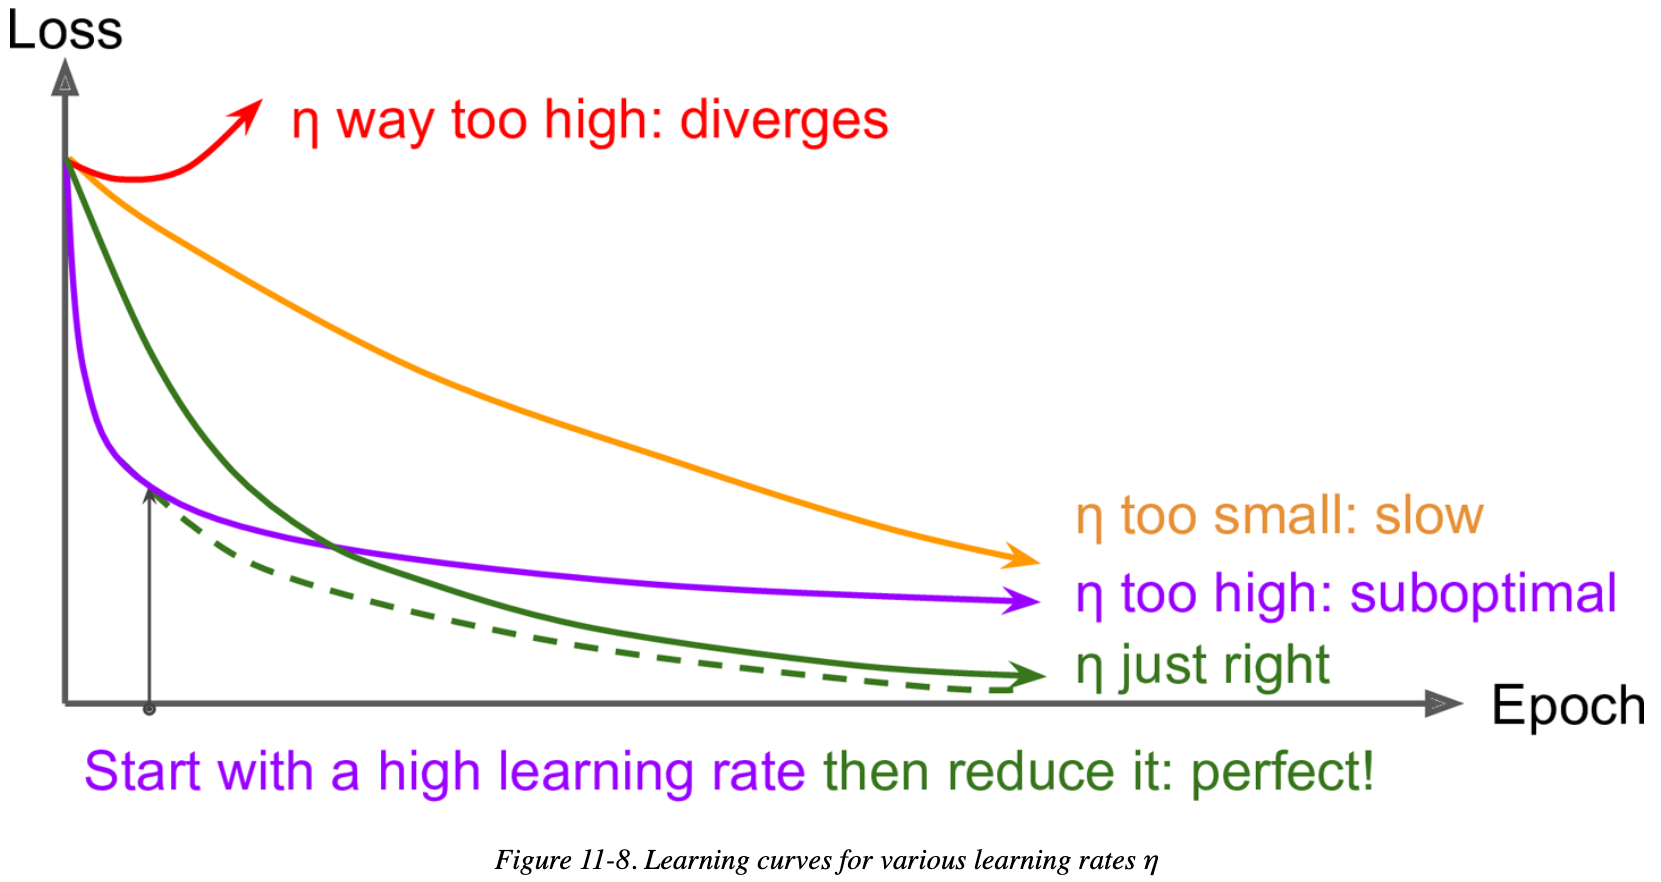

Note that gradient descent is also useful for regression where too many training points (or too many features) to fit into memory.

Scikit-Learn has both [unsupervised Neural Network](http://scikit-learn.org/stable/modules/neural_networks_unsupervised.html#neural-networks-unsupervised) and [supervised Neural Network](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised) examples. 

Last time we saw an example from Geron where we apply gradient descent to a simple linear regression problem.

Today, let's try to use the multi-layer perceptron classifier on the California House Price dataset (using 75% of the data for training and 25% for testing).

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

X = housing.data
y = housing.target
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn import preprocessing
Xtrain_scaled = preprocessing.scale(Xtrain)
Xtest_scaled = ____
Xscaled = ____

Train a neural network with 2 hidden layers having 5 and 2 nodes, respectively.

In [ ]:
from sklearn.neural_network import ____
clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(____,____), random_state=1, max_iter=5000)
____.____(Xtrain_scaled, ytrain)

# Look at the weights
print([coef.shape for coef in clf.coefs_])

ypred = clf.____(____)
#print ypred, ytest

fig = plt.figure(figsize=(6, 6))
plt.scatter(ytest,ypred)
plt.xlabel("Actual Value [x$1000]")
plt.ylabel("Predicted Value [x$1000]")
plt.show()

In [ ]:
print(clf.coefs_)

Of course, that only predicts the value for a fraction of the data set. 

Again, we can use Scikit-Learn's [cross_val_predict](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) to make predictions for the full data set.

In [ ]:
from sklearn.model_selection import cross_val_predict

yCVpred = cross_val_predict(clf, Xscaled, y, cv=5) # Complete

fig = plt.figure(figsize=(6, 6))
plt.scatter(y,yCVpred)
plt.xlabel("Actual Value [x$1000]")
plt.ylabel("Predicted Value [x$1000]")
plt.show()

Just as with other model hyperparameters, we can use cross-validation to determine the optimal number of layers, neurons per layer, etc. But for now, let's talk about some guidelines.

### Number of Layers

Ivezic: 

> "*For data that can be represented by a linear model, no layers are required (McCullagh & Nelder 1989).  A single layer network can approximate any continuous function.  Two layers can represent arbitrary decision boundaries for smooth functions (Lippmann 1987).  More layers can represent non-continuous or complex structure within the data.*"  

Think about why no layers are needed for linear regression.  We just connect our input to the output where the synapses are the weights (slopes) and the output neurons add the constant (intecept).

So you might start with a single layer, then add more layers and use cross-validation to determine when you are overfitting.

Geron has a good example of what adding layers does.  Say you had to draw a whole forest, but you couldn't cut and paste anything.  That would be very tedious.  But if you could draw just one leaf and copy that to make a small branch, then scale up a small branch to a big branch and copy that, then attach the branches to a tree trunk and then make copies of the full tree, you wouldn't have to draw all that much.  **Each of the layers in a neural network handles  more and more detailed aspects of the problem.**

For image recognition, you might need dozens of layers, but also a huge training set to populate those layers.

### Number of Neurons

The number of neurons in each layer is also a free parameter. 

- ***Typically choose somewhere between twice the number of input nodes and a number between the number of input and output nodes.***


- If there are lots hidden layers (where "lots" is not clearly defined) then we call that a **deep neural network or [deep learning](https://en.wikipedia.org/wiki/Deep_learning)**. 


- Sometimes the number of neurons in each layer goes down.  But it can also be useful to have the same number in each layer so that there is only one hyperparameter (the number of neurons) and not one per layer.


- In practice a reasonable approach is to simply **specify many more layers and neurons than you need and perform regularization**. This can be as simple as just stopping the training when the cross-validation error reaches a minimum, which appropriately (for once) is called **[early stopping](https://en.wikipedia.org/wiki/Early_stopping)**. Basically, you put your `fit` method into a loop and instantiate with `max_iter=1` and `warm_start=True`.  See Geron (page 141) for an example.


While the number of neurons in the hidden layers are free parameters, the number of input and output nodes are constrained by the data and the desired output.  For example, the MNIST digits data requires 784 input neurons (one for each pixel in the 28x28 images) and 10 output neurons (one for each class [digit]).  

## Activation Functions  <a class="anchor" id="three"></a>

The **[Activation function](https://en.wikipedia.org/wiki/Activation_function)** controls how much "signal" it takes for a neuron to "fire".  The more signal, the more likely the neuron will fire. See https://mlfromscratch.com/activation-functions-explained/#/

The cells below show different activation functions, using the same visualization as we used for loss functions.

In [ ]:
# Mathematical formulas for activation functions
  
def binary(raw_model_output):
    return np.where(raw_model_output < 0, 
                    0, 
                    1)  

def sigmoid(raw_model_output):
    return 1.0 / (1 + np.exp(-raw_model_output))

def ReLU(raw_model_output):
    return np.where(raw_model_output < 0, 
                    0, 
                    raw_model_output)

def LReLU(raw_model_output):
    alpha=0.1
    return np.where(raw_model_output < 0, 
                    alpha*raw_model_output, 
                    raw_model_output)

In [ ]:
# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
#plt.plot(grid, log_loss(grid), label='logistic')
plt.plot(grid, binary(grid), "k", label='binary')
plt.plot(grid, sigmoid(grid), "b", label='sigmoid')
#plt.plot(grid, ReLU(grid), label='ReLU')
#plt.plot(grid, LReLU(grid), label='LReLU')
#plt.plot(grid, l2(grid), label='L2')
#plt.plot(grid, l1(grid), label='L1')

plt.fill_between([0,3], y1=-1, y2=3, 
                 color="b", alpha=0.2)
plt.fill_between([-3,0], y1=-1, y2=3, 
                 color="r", alpha=0.2)
plt.xlim([-3,3])
plt.ylim([-1,3])
plt.xlabel("z",fontsize=12)
plt.title("don't fire                 fire",fontsize=12)
plt.legend()

plt.show()

"*On vs. Off*" activation actually isn't quite true or what we want. The way your eyes work is that you need 1-10 photons to trigger a *rod*, but several rods must be triggered to send a signal to the brain. The sigmoid activation function captures the probabilistic nature of neuron firing. More importantly it is differentiable, so can be used for backpropagation.

Another important aspect of non-linear activation functions is that they are what allow neural networks to solve non-linear problems.  If we used a strictly linear activation function, then we could only solve linear problems.  That is, you could fit a straight line, but not an exponential.

If you wanted to make the activation function a parameter, here's how to find out what your options are

In [ ]:
#Different activation functions that are available
[m for m in dir(keras.activations) if not m.startswith("_")]

### Vanishing and Exploding Gradients

Neural network research suffered significant limitations and problems at the hands of the [vanishing and exploding gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem.  We won't go into detail there except to say that ***around 2010 there were suggestions for different activation functions that were published.***  

- For example, the **[Rectified Linear Unit (ReLU) activation function](https://www.wikiwand.com/en/Rectifier_(neural_networks))** is another commonly used activation function as it solves the vanishing gradient problem (since the gradient is only 0 or 1).
$${\rm ReLU}(z) = max(0,z)$$


- It isn't ideal both because the derivative is 0 for $z<0$ and it can end up producing dead nodes. However, it is fast and the resulting sparsity can be good (sort of like regularization).


- A number of papers since 2015 describe various improvements, including the **Leaky ReLU**, the **exponential linear unit (ELU)**, **scaled exponential linear unit (SELU)**, and **Swish**.


Note that the activation functions can be different in different layers.  For example, for regression, one typically doesn't use any activation function in the output layer as including one would restrict the range of possible outputs

In [ ]:
# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
#plt.plot(grid, log_loss(grid), label='logistic')
#plt.plot(grid, binary(grid), "k", label='binary')
#plt.plot(grid, sigmoid(grid), "b", label='sigmoid')
plt.plot(grid, ReLU(grid), "b--", label='ReLU')
plt.plot(grid, LReLU(grid), "orange", label='LReLU')
#plt.plot(grid, l2(grid), label='L2')
#plt.plot(grid, l1(grid), label='L1')

plt.fill_between([0,3], y1=-1, y2=3, 
                 color="b", alpha=0.2)
plt.fill_between([-3,0], y1=-1, y2=3, 
                 color="r", alpha=0.2)
plt.xlim([-3,3])
plt.ylim([-1,3])
plt.xlabel("z",fontsize=12)
plt.title("don't fire                       fire",fontsize=12)
plt.legend()

plt.show()

Some general guidance on activation functions:
    
* **Use sigmoid for output of binary classification (with binary cross entropy loss)**


* **Use ReLU for layers other than output (at least to start with because it is faster)**


* **Use softmax for output with more than 2 classes (with categorical cross entropy loss)**

### Faster Optimizers

We aren't going to talk about optimizers, but it might be useful for you to have some options to feed into a search for the best parameter using cross validation.  For example **`['mse', 'adam', 'sgd', 'adagrad']`**.

---

If we want to do anything more complicated, we'll need to use something other than Scikit-Learn.  Enter Keras and TensorFlow.

## Keras  <a class="anchor" id="four"></a>

**[Keras](https://keras.io/)** is a **deep learning** API. Essentially it is Scikit-Learn for deep neural networks.

Keras needs a computational backend to handle the heavy computation.  Three popular (open sources) deep learning libraries are [TensorFlow](https://www.tensorflow.org/), Microsoft Cognitive Toolkit, and [Theano](http://www.deeplearning.net/software/theano/). TensorFlow now comes bundled with a version of Keras and that's what we'll use here (actually TensorFlow 2). PyTorch is another option.  Section 9.8 of Ivezic includes examples using both `keras` and `torch`.

If you apply for a data-science job in industry, knowing one of these tools might be the most useful thing for you to have learned.

In short, for neural networks:

> numpy -> tensorflow

> sklearn -> keras

In the same way that you can build a linear regression algorithm in numpy without using sklearn, you can build a neural network algorithm (not to mention linear regression) in tensorflow without using keras.  But just as sklearn makes our life easier, so too does keras.  

Keras has Sequential and Functional APIs.  We will just use Sequential in our examples.

Just as I'm teaching you about sklearn and not numpy, I have no intention of teaching you tensorflow.  

The following cells are from Geron, Chapter 10, see 
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

I'll indicate below when I switch chapters.

We'll start by introducing the Fashion MNIST data set, which is as common for learning about neural networks as the MNIST are for machine learning in general.  We can also use the MNIST data too.

The next cells load the data, define test, trainging, and validation sets; normalize the data; display an example image; list the possible target values ($y$), and show a 4x10 grid of examples.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.shape)
print(X_test.shape)

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

In [ ]:
plt.imshow(X_train[0], cmap="binary", origin='upper') #Origin controls right-side up
plt.axis('off')
plt.show()

Take a look at some of the other entries in the training data.  Also see what happens when you remove the `origin='upper'` parameter.

In [ ]:
#Let's make a list of class names that we can refer to.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
# Plot 4x10 array of images from the Fashion MNIST database
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest", origin='upper')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Now we'll build a "simple" neural network that classifies an unknown image (preprocessed to have the same image and color scale) into one of these 10 categories.

In [ ]:
keras.backend.clear_session() #Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) #Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential() #Instantiate a sequential model
model.add(keras.layers.Flatten(input_shape=[28, 28])) #Define the input layer
model.add(keras.layers.Dense(300, activation="relu")) #First hidden layer
model.add(keras.layers.Dense(100, activation="relu")) #Second hidden layer
model.add(keras.layers.Dense(10, activation="softmax")) #Output layer

Need to define the input size/shape for the first layer.  The others know how to talk to each other.  The last layer sets the number of outputs.  Need softmax here because there are 10 categories.  If just one output or two, then a different activation function would be used.

In [ ]:
#Let's see what we just built
model.summary()

The number of parameters in each layer is one for each weight that connects each node of the layer to the previous layer, plus the number of neurons in the layer to account for the constant "bias" parameter (e.g., 784x300+300 = 235500).

Note that "Dense" here means "fully connected".  That is, each node in one layer is connected to each node in the next layer.  This doesn't always have to be the case.  The layers can instead be "Sparse".

We can access (or set) the weights with `get_weights()` and `set_weights()` as follows.  Note that the initial weights are set randomly and the bias values are initially zero.

In [ ]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
#Weights set to random numbers to break degeneracy
#Biases are set to 0
print(weights.shape,weights,biases)

For neural networks we can't just fit the model after we instantiate it.  We need to compile first--specifying the loss function, the optimizer, and any desired metrics.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Now we can go ahead and fit the model with our training data.  The fit method will output a bunch of useful diagnostics that we'll save to `history` for plotting later.

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Comment on what is happening with loss, val_loss, and accuracy.

Validation flattens around 30 if we let it keep running.

Our metrics of interest were printed at each epoch (each pass through the neural network to update the weights), but it is easier to just look at a plot!

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epoch")
plt.show()

As was the case for model training before, we want to make sure that we aren't overtraining, which would be indicated by the training loss diverging from the validation loss.  Note that, instead of creating a specific validation set, we can also pass `validation_split=0.1` as a parameter during the fitting step to split off 10% of the data for validation.

Now we will `evaluate` the model using the test set to determine the expected level of error on unknown data.    The usual `predict` method then can be used to make predictions.  [GTR: I'm not sure the reason for this structure.  In regular ML we would `predict` on the test set and the compute metrics with the output values.]

In [ ]:
#Evaluate the test set
model.evaluate(X_test, y_test)

In [ ]:
#Predict values for first 3 test objects
X_new = X_test[:3]
y_proba = model.predict(X_new).round(2)
print(y_proba)

So, you can see that the output is a probability that the object belongs to each class (which has to sum to 1 across all the classes).  If we just want an "answer", we assign it to the class with the highest probability (done here with `predict_classes`).

In [ ]:
#y_pred = model.predict_classes(X_new) #Old way
y_pred = np.argmax(model.predict(X_new), axis=-1) #New way
print(y_pred)
print(np.array(class_names)[y_pred])

In [ ]:
#Let's plot those and see if the predictions make sense.
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

Note that after you fit your model, you can save it and reload it at some later time (which is good because some models might take hours to train!)

In [ ]:
#Save model
model.save("my_keras_model.h5")

#Reload model
model = keras.models.load_model("my_keras_model.h5")

Let's predict the values for 10 random objects.  Display them with their actual labels first, then predict and display the predictions.

In [ ]:
idx10 = np.random.choice(np.arange(len(y_test)), size=10, replace=False)
X_new = X_test[idx10]
#y_pred = model.predict_classes(X_new)
y_pred = np.argmax(model.predict(X_new), axis=-1)

In [ ]:
#Correct answers (y_test)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[idx10[index]]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
#Predicted answers (y_pred)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_pred[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

---

Here's a regression example instead of classification, using the California housing data again.

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(X_test.shape)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)

#X_new = X_test
y_pred = model.predict(X_test)

In [ ]:
print(y_pred)

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test,y_pred)
plt.xlabel("Actual Value [x$1000]")
plt.ylabel("Predicted Value [x$1000]")
plt.show()

---

## Regularization  <a class="anchor" id="five"></a>

Just as we can use regularization for standard regression and classification tasks, so too can we with neural networks.  

Not only can we apply the usual $L1$ (LASSO) or $L2$ (Ridge) regularization techniques, we can also use **dropout** which, as the name indicates, causes some neurons to be temporarily "dropped out" during training (usually by setting some probability for that to happen, typically 10-50%). After training, all of the neurons are used.

*Geron* explains this in terms of a company needing to try to figure out how to adapt to a crucial employee being out sick for a period of time.  In the end, it can make the company stronger as more people (neurons) are able to handle certain parts of the process.

One form of regularization is  "early stopping".  This will determine when there hasn't been any improvement in the validation set for `patience` epochs and stop the fitting.  It also uses the "best" weights and just the "last" weights.

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Note that we told it that it could run for as many as 100 epochs if it wanted to, but it stopped after 74.

Now we can plot the results.

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epoch")
plt.show()

Here's an example of how to do regularization with [dropout](https://en.wikipedia.org/wiki/Dilution_(neural_networks)).

![DropoutDiagram](https://miro.medium.com/max/1400/1*tvcv2PT3cBAmUtZzQTmjeQ.png)

In [ ]:
#Back to the fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [ ]:
#Dropout example
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), #20% chance of neuron stuck in off position
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

---

## Batch normalization  <a class="anchor" id="six"></a>

Just as it is often necessary to normalize or standardize our features, sometimes it is helpful to do the same to the output of the hidden layers.  This is called **[batch normalization](https://en.wikipedia.org/wiki/Batch_normalization)** and is done before passing the data to the activation function.  It make the process more stable and can also make it faster.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

In some cases you might want to do the batch normalization before applying the activation function.  Here we also turn off the bias parameter because it ends up not being needed and just wastes a parameter.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

---

Now let's use cross validation to determine the best options.  Here we have so many that we'll use [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead of `GridSearchCV`.

First we need to do some preprocessing to get sklearn and keras to talk nicely to each other.

Start by building the model in a way that the hyperparameters are themselves parameters, then wrap that model in a way that we can use it within sklearn.

See
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

In [ ]:
def build_model(n_hidden=1, n_neurons=10, learning_rate=3e-3, input_shape=[28,28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden): #Because the number of hidden layers is a parameter
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax")) #Output layer
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [ ]:
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)
#Note that there is also a KerasRegressor for regression problems.

`keras_class` can now be used with in sklearn in the same way as any other classifier.  For example:

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    #"n_hidden": [0, 1, 2, 3],
    "n_hidden": (0, 1),
    #"n_neurons": np.arange(1, 30), #This would take too long for class!
    "n_neurons": (5,10),
    #"learning_rate": reciprocal(3e-4, 3e-2) #Not quite sure what this does, but it makes it take forever!
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, verbose=2)

We'll try this on the MNIST digits data.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.
X_new = X_test[:10]
y_new = y_test[:10]

In [ ]:
plt.imshow(X_train[0], cmap="binary", origin="upper")
plt.axis('off')
plt.show()

Note that we are doing 3-fold cross validation, so the validation set isn't being used for training, just for early stopping.

In [ ]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.cv_results_)